# Import Data

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.ticker as ticker
import sys
import os
import warnings

## Import Functions from ts_functions.py

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
import src.ts_functions as ts_functions

In [5]:
warnings.filterwarnings('ignore')

#Read in data.  Zipcode is string to keep leading 0's
data_path = os.path.join(os.pardir, "Zillow_data", "zhvi_all-homes_zipcode.csv")
raw_data = pd.read_csv(data_path, dtype={'RegionName': object})
raw_data.head(3)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,233265.0,...,1248340.0,1234262.0,1229890.0,1226466.0,1208024.0,1182758.0,1150900.0,1134880.0,1120949.0,1112549.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,211748.0,...,494425.0,493485.0,492514.0,491726.0,491562.0,492618.0,494017.0,494766.0,494546.0,494435.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,245773.0,...,1161916.0,1153259.0,1156287.0,1175142.0,1193746.0,1205413.0,1203165.0,1209735.0,1211403.0,1212520.0


Imported data as Pandas DataFrame and stored in raw_data variable.  raw_data is in Wide format.  We will need to convert it to Long format before doing time series analysis.

# Data Cleaning

In [6]:
df = ts_functions.clean_data(raw_data)

Melted data into long format for proper time series analysis.  Removed unneeded columns and properly named the 'zipcode' column.  Replaced missing 'Metro' values with 'rural' since we assume that missing values indicate that a zipcode is not in a metro area.  We also removed data for 2020 dates because we only want to model on data that captures a full year.  Now the data is in a format that is usable for time series analysis.

# Pre-Modeling - Top 5 Codes Since 1996

In this section we begin getting our data ready for modeling.  We chose to model the 5 zipcodes with the highest growth since the beginning of our data (1996).  This decision was made in the EDA stage.  All of these zipcodes are in California.  Other EDA analysis points to the growth and recession-resistant nature of properties in California.

### Preprocessing & Viz

In [7]:
codes_full_range = ['91108', '90211', '90027', '94610', '90048']
top_full_range = ts_functions.get_codes_data(df, codes_full_range)
fr_list = ts_functions.split_data_by_code(top_full_range, codes_full_range)

Filtered down raw_data to only contain data for specific zipcodes.  The zipcodes are those where median prices have increased the most in the time range 1996-2019.  Then separated out data for each zipcode so that it can be analyzed and graphed separately.  These separated DataFrames are stored in fr_list.

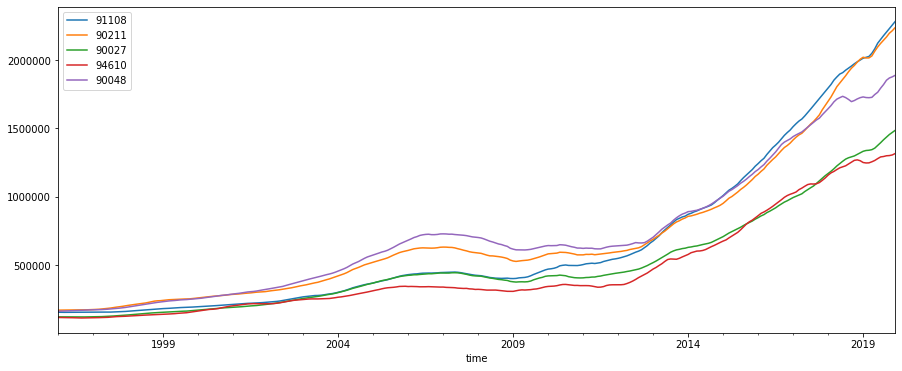

In [9]:
ts_functions.plot_trends(fr_list, codes_full_range)

Visualize how median value changes over time for the top 5 zipcodes.  We can see that there was only a marginal drop in property values during the recession.

### Assumptions & Best Parameters

In [10]:
fr_train, fr_test = ts_functions.ts_train_test_split(fr_list, 0.71)

Here we split each dataframe in fr_list into train and test sets.  This allows for model validation at the end of the process.  We chose a split ratio of 71% training data so that we could train on data before and after the recession.  This number also splits the train and test data at the end of the year, so we capture the full yearly cycle in our data.

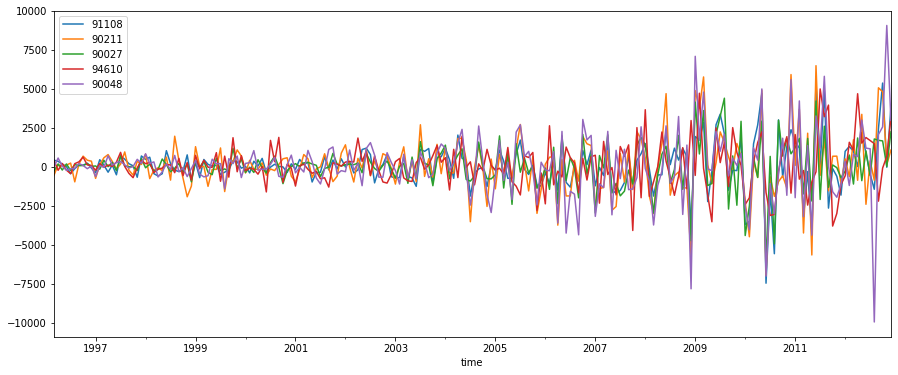

In [11]:
fr_diff = ts_functions.get_difference(fr_train)
ts_functions.plot_diff_trends(fr_diff, codes_full_range)

The unaltered data contained in fr_list was not stationary.  Stationarity is a requirement for most time series modeling and analysis.  To correct this we transform the data using 2 orders of differencing.  This differenced data is stored in fr_diff.  Then, to visually inspect the stationarity, we plot the newly differenced data over time.  We can see that variance may be increasing over time, so we need to perform a Dickey-Fuller test to see if each dataframe can be considered stationary.

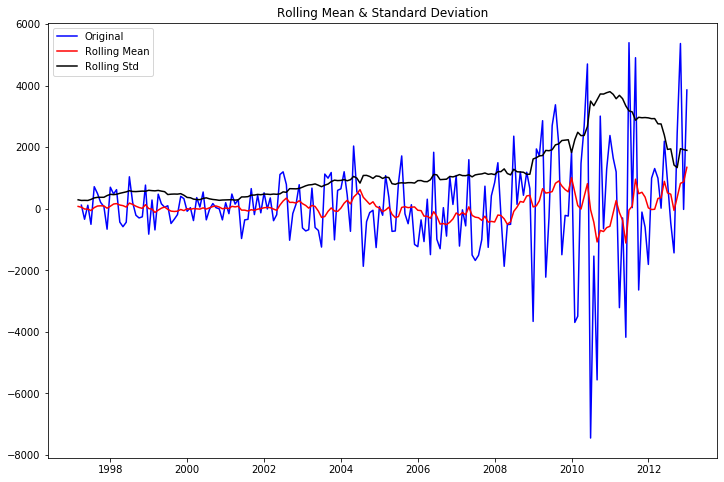

Results of Dickey-Fuller Test:
Test Statistic                  -2.524895
p-value                          0.109534
#Lags Used                      15.000000
Number of Observations Used    186.000000
Critical Value (1%)             -3.466005
Critical Value (5%)             -2.877208
Critical Value (10%)            -2.575122
dtype: float64


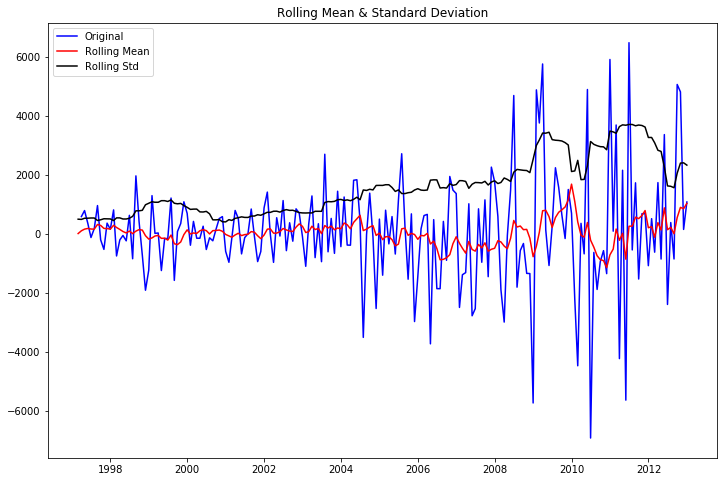

Results of Dickey-Fuller Test:
Test Statistic                  -3.631912
p-value                          0.005179
#Lags Used                      14.000000
Number of Observations Used    187.000000
Critical Value (1%)             -3.465812
Critical Value (5%)             -2.877123
Critical Value (10%)            -2.575077
dtype: float64


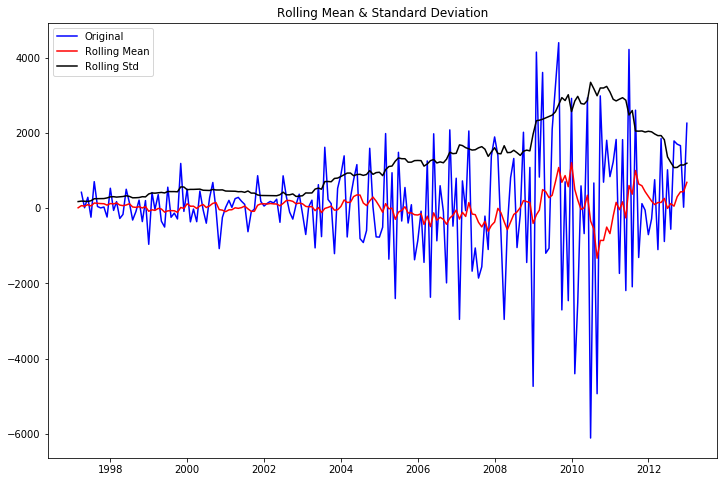

Results of Dickey-Fuller Test:
Test Statistic                  -4.365633
p-value                          0.000341
#Lags Used                      14.000000
Number of Observations Used    187.000000
Critical Value (1%)             -3.465812
Critical Value (5%)             -2.877123
Critical Value (10%)            -2.575077
dtype: float64


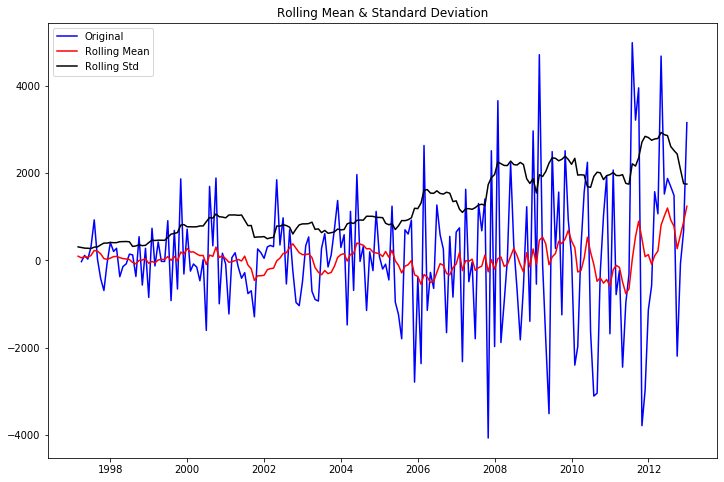

Results of Dickey-Fuller Test:
Test Statistic                  -2.890590
p-value                          0.046453
#Lags Used                      12.000000
Number of Observations Used    189.000000
Critical Value (1%)             -3.465431
Critical Value (5%)             -2.876957
Critical Value (10%)            -2.574988
dtype: float64


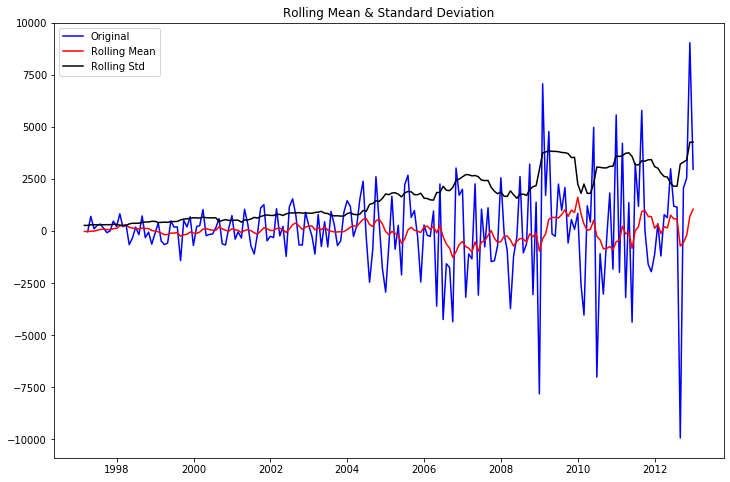

Results of Dickey-Fuller Test:
Test Statistic                  -4.537964
p-value                          0.000168
#Lags Used                      13.000000
Number of Observations Used    188.000000
Critical Value (1%)             -3.465620
Critical Value (5%)             -2.877040
Critical Value (10%)            -2.575032
dtype: float64


In [12]:
ts_functions.test_station_of_list(fr_diff, 12)

The visual inspection of stationarity in the previous step looked promising, but is not enough to make a conclusion on.  In this step we conduct a Dickey-Fuller test for the data of each zipcode contained in fr_diff.  The p-values below the threshold of 0.05 allows us to **reject** the null hypothesis that our data is **not** stationary.  

The p-value of the test on the first zipcode is too high to reject the null hypothesis at our alpha threshold of 0.05.  Ideally we would manipulate this data further to induce stationarity, but due to time constraints we will leave this for the next iteration of this project.

## Model Hyper-Parameter Selection

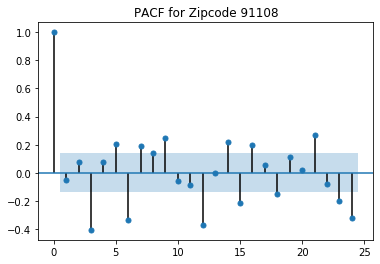

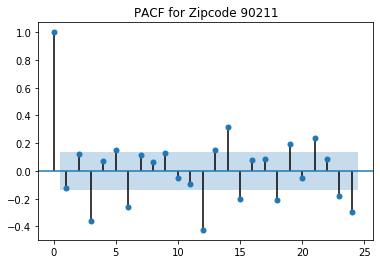

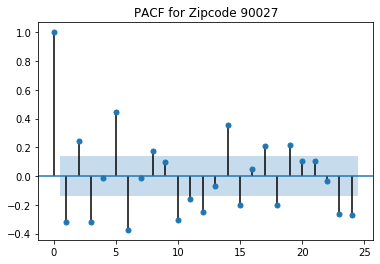

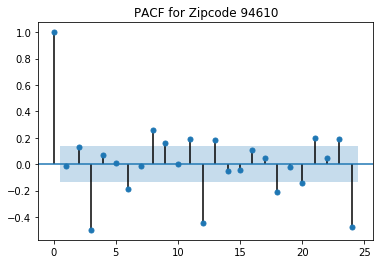

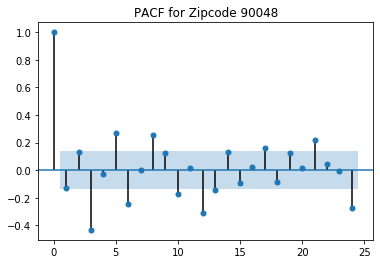

In [13]:
ts_functions.plot_all_pacf(fr_diff, codes_full_range)

These graphs show partial autocorrelation for the differenced data of each zipcode.  The values outside of the confidence interval give us a starting point for AR parameters to try when fitting our ARIMA model.  These graphs indicate that we should try AR term values of 0, 2, 3, 6, and 12.  We do this below, and take the parameter that yields the best results (in terms of AIC) to use in our modeling.

In [14]:
ar_values = [0, 2, 3, 6, 12]
best_ar_values = []

# Loop through possible AR terms and add the best one for each dataset to best_ar_values
for i in range(len(fr_train)):
    for x in range(len(ar_values)):
        best_ar = 0
        best_aic = 9999999
        #Try this with 0 MA term
        model = ARIMA(fr_train[i], (ar_values[x],2,0)).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_ar = ar_values[x]
    print("Best AR Value is: " + str(best_ar))
    best_ar_values.append(best_ar)

Best AR Value is: 12
Best AR Value is: 12
Best AR Value is: 12
Best AR Value is: 12
Best AR Value is: 12


In [15]:
best_ar_values

[12, 12, 12, 12, 12]

An AR term of 12 in the ARIMA model results in the lowest AIC value for each zipcode.  We will use AR == 12 in all models.

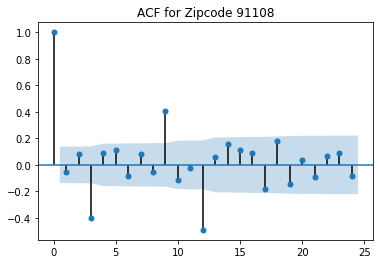

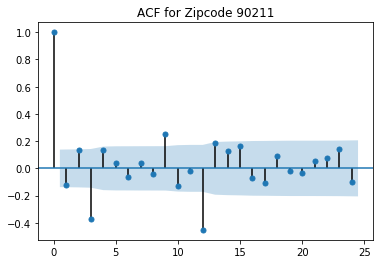

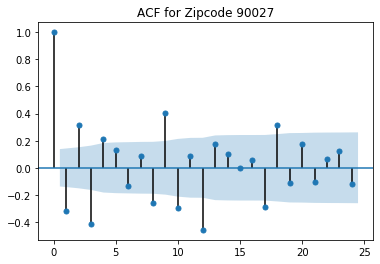

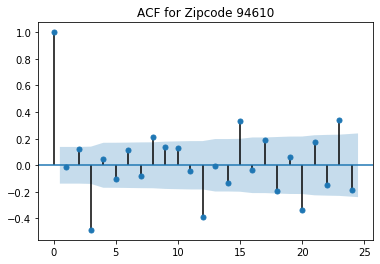

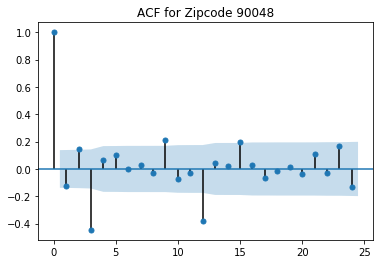

In [16]:
ts_functions.plot_all_acf(fr_diff, codes_full_range)

Now we repeat the above process, except we use ACF plots to determine our MA term in our ARIMA models.  These graphs show autocorrelation for the differenced data of each zipcode.  The negative values outside of the confidence interval give us a starting point for MA parameters to try when fitting our ARIMA model.  We will test the models on MA terms of 0, 1, 3, and 12.

In [17]:
ma_values = [0, 1, 3, 12]
best_ma_values = []

#Loop through possible MA terms and store the best one for each zipcode in best_ma_values
for i in range(len(fr_train)):
    for x in range(len(ma_values)):
        best_ma = 0
        best_aic = 9999999
        model = ARIMA(fr_train[i], (0,2,ma_values[x])).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_ma = ma_values[x]
    print("Best MA Value is: " + str(best_ma))
    best_ma_values.append(best_ma)

Best MA Value is: 0
Best MA Value is: 0
Best MA Value is: 12
Best MA Value is: 0
Best MA Value is: 0


In [18]:
best_ma_values

[0, 0, 12, 0, 0]

Using AR parameter of 0 shows us that the best choice for the MA term in most cases is 0.  In one case the best choice is 12, but AR and MA values cannot both be 12.  Therefore we will use 0 as the MA term for this model. MA parameter of 0 in our ARIMA model results in the lowest AIC score, so now we will fit our models with parameters of MA == 0, AR ==12, and Differencing == 2.


# Modeling - Top 5 Codes Since 1996

Now that we have prepared our data and determined the best hyperparameters to use, we our ready to fit our 5 models.  Each model corresponds to data from one zipcode with parameters of ARIMA(12,2, 0).  

The models for each dataset are stored in the list model_list.  The training predictions for each model are stored in the list train_pred_list.

In [19]:
model_list = []
train_pred_list = []

ts_functions.fit_arima(fr_train[0]['value'], model_list, train_pred_list, 12, 2, 0)
ts_functions.fit_arima(fr_train[1]['value'], model_list, train_pred_list, 12, 2, 0)
ts_functions.fit_arima(fr_train[2]['value'], model_list, train_pred_list, 12, 2, 0)
ts_functions.fit_arima(fr_train[3]['value'], model_list, train_pred_list, 12, 2, 0)
ts_functions.fit_arima(fr_train[4]['value'], model_list, train_pred_list, 12, 2, 0)

([<statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x1336c8da0>,
 [1996-03-31    152756.945883
  1996-04-30    152970.520592
  1996-05-31    153541.208130
  1996-06-30    153927.540652
  1996-07-31    154353.893322
                    ...      
  2012-08-31    599697.240875
  2012-09-30    609770.764762
  2012-10-31    622541.452718
  2012-11-30    643171.604174
  2012-12-31    657494.959459
  Freq: M, Length: 202, dtype: float64, 1996-03-31    170232.861701
  1996-04-30    169799.423715
  1996-05-31    169929.554281
  1996-06-30    170513.023543
  1996-07-31    170662.141226
                    ...      
  2012-08-31    624515.314415
  2012-09-30    630728.871496
  2012-10-31    642883.928461
  2012-11-30    660979.942174
  2012-12-31    675300.533819
  Freq: M, Length: 202, dtype: float64, 1996-03-31    120095.878677
  1996-04-30    119742.135314
  1996-05-31    119723.596294
  1996-06-30    119596.656004
  1996-07-31    119503.730474
                    ...      
  2012-08-31    

Now that we have fit our models on the training data, we make predictions on our test data.  This will allow us to judge the accuracy and predictive ability of our model.

In [20]:
# Use models to make predictions on test data
pred_list_test = []

for i in range(len(model_list)):
    test_pred = model_list[i].predict(start=fr_test[i].index[0], end=fr_test[i].index[-1],typ='levels')
    pred_list_test.append(test_pred)

pred_list_test    

[2013-01-31    6.782906e+05
 2013-02-28    6.980272e+05
 2013-03-31    7.157514e+05
 2013-04-30    7.338455e+05
 2013-05-31    7.521386e+05
                   ...     
 2019-08-31    2.237795e+06
 2019-09-30    2.260582e+06
 2019-10-31    2.283407e+06
 2019-11-30    2.306330e+06
 2019-12-31    2.329436e+06
 Freq: M, Length: 84, dtype: float64, 2013-01-31    6.896325e+05
 2013-02-28    7.046337e+05
 2013-03-31    7.178500e+05
 2013-04-30    7.314517e+05
 2013-05-31    7.440436e+05
                   ...     
 2019-08-31    1.717914e+06
 2019-09-30    1.732797e+06
 2019-10-31    1.747778e+06
 2019-11-30    1.762862e+06
 2019-12-31    1.777993e+06
 Freq: M, Length: 84, dtype: float64, 2013-01-31    5.183855e+05
 2013-02-28    5.309771e+05
 2013-03-31    5.426526e+05
 2013-04-30    5.540586e+05
 2013-05-31    5.661123e+05
                   ...     
 2019-08-31    1.387758e+06
 2019-09-30    1.400432e+06
 2019-10-31    1.413129e+06
 2019-11-30    1.425847e+06
 2019-12-31    1.438641e+06
 F

# Forecasting - Top 5 Codes Since 1996

Now we are ready for the forecasting stage.  We will project out our model 5 years into the future to determine the likely value of investments in each zipcode for the investor's 5 year time horizon.

First we create a date range for the time period that we are forecasting to (2020-2024).  In the next step we combine this with our model's forecasts so that we can graph the forecasts.

In [21]:
forecast_range = pd.date_range(start="2020-01-01",end="2025-01-01", freq='M')
forecast_range

DatetimeIndex(['2020-01-31', '2020-02-29', '2020-03-31', '2020-04-30',
               '2020-05-31', '2020-06-30', '2020-07-31', '2020-08-31',
               '2020-09-30', '2020-10-31', '2020-11-30', '2020-12-31',
               '2021-01-31', '2021-02-28', '2021-03-31', '2021-04-30',
               '2021-05-31', '2021-06-30', '2021-07-31', '2021-08-31',
               '2021-09-30', '2021-10-31', '2021-11-30', '2021-12-31',
               '2022-01-31', '2022-02-28', '2022-03-31', '2022-04-30',
               '2022-05-31', '2022-06-30', '2022-07-31', '2022-08-31',
               '2022-09-30', '2022-10-31', '2022-11-30', '2022-12-31',
               '2023-01-31', '2023-02-28', '2023-03-31', '2023-04-30',
               '2023-05-31', '2023-06-30', '2023-07-31', '2023-08-31',
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
               '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
               '2024-05-31', '2024-06-30', '2024-07-31', '2024-08-31',
      

### Plot Forecast for Zipcode 91108

Text(0.028, 0.52, '5 Year Forecast: $3.8M')

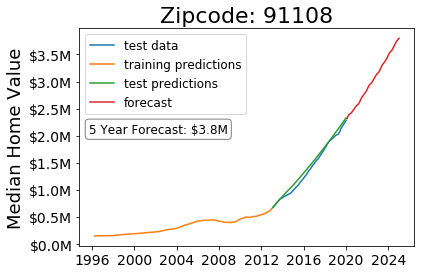

In [22]:
fig, ax = plt.subplots()

# Re-fit model for forecasts using train AND test data
model_for_forecast = ARIMA(fr_list[0], (12,2,0)).fit()
forecast = model_for_forecast.forecast(steps=60)

# Plot train, test, predictions
ax.plot(fr_test[0], label='test data')
ax.plot(train_pred_list[0], label='training predictions')
ax.plot(pred_list_test[0], label='test predictions')
ax.plot(pd.DataFrame(forecast[0], index = forecast_range), label='forecast')

# Set title and axis labels
plt.title("Zipcode: " + codes_full_range[0], fontsize=22)
plt.ylabel("Median Home Value", fontsize=18)

#Format y axis for millions of dollars
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$' + '{:,.1f}'.format(x/1000000.0) + 'M'))

# Adjust Font Size
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12)

# Add Text Box Showing Forecasted Value in 5 Years
textstr = '5 Year Forecast: $' + str(round(forecast[0][-1] / 1000000, 1)) + 'M'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.028, 0.52, textstr, transform=ax.transAxes, fontsize=12, bbox=props)

### Plot Forecast for Zipcode 90211

Text(0.028, 0.52, '5 Year Forecast: $3.8M')

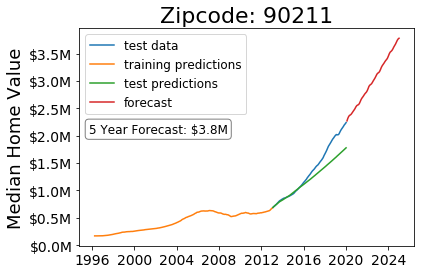

In [23]:
fig, ax = plt.subplots()

# Re-fit model for forecasts using train AND test data
model_for_forecast = ARIMA(fr_list[1], (12,2,0)).fit()
forecast = model_for_forecast.forecast(steps=60)

# Plot train, test, predictions
ax.plot(fr_test[1], label='test data')
ax.plot(train_pred_list[1], label='training predictions')
ax.plot(pred_list_test[1], label='test predictions')
ax.plot(pd.DataFrame(forecast[0], index = forecast_range), label='forecast')

# Set title and axis labels
plt.title("Zipcode: " + codes_full_range[1], fontsize=22)
plt.ylabel("Median Home Value", fontsize=18)

#Format y axis for millions of dollars
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$' + '{:,.1f}'.format(x/1000000.0) + 'M'))

# Adjust Font Size
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12)

# Add Text Box Showing Forecasted Value in 5 Years
textstr = '5 Year Forecast: $' + str(round(forecast[0][-1] / 1000000, 1)) + 'M'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.028, 0.52, textstr, transform=ax.transAxes, fontsize=12, bbox=props)

### Plot Forecast for Zipcode 90027

Text(0.028, 0.52, '5 Year Forecast: $2.4M')

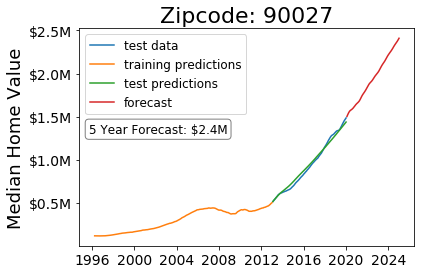

In [24]:
fig, ax = plt.subplots()

# Re-fit model for forecasts using train AND test data
model_for_forecast = ARIMA(fr_list[2], (12,2,0)).fit()
forecast = model_for_forecast.forecast(steps=60)

# Plot train, test, predictions
ax.plot(fr_test[2], label='test data')
ax.plot(train_pred_list[2], label='training predictions')
ax.plot(pred_list_test[2], label='test predictions')
ax.plot(pd.DataFrame(forecast[0], index = forecast_range), label='forecast')

# Set title and axis labels
plt.title("Zipcode: " + codes_full_range[2], fontsize=22)
plt.ylabel("Median Home Value", fontsize=18)

#Format y axis for millions of dollars
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$' + '{:,.1f}'.format(x/1000000.0) + 'M'))

# Adjust Font Size
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12)

# Add Text Box Showing Forecasted Value in 5 Years
textstr = '5 Year Forecast: $' + str(round(forecast[0][-1] / 1000000, 1)) + 'M'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.028, 0.52, textstr, transform=ax.transAxes, fontsize=12, bbox=props)

### Plot Forecast for Zipcode 94610

Text(0.028, 0.52, '5 Year Forecast: $1.8M')

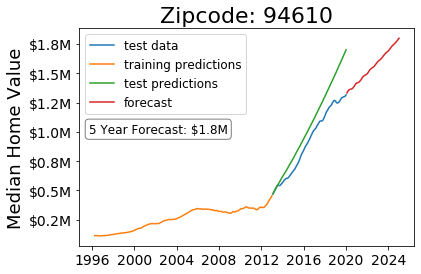

In [25]:
fig, ax = plt.subplots()

# Re-fit model for forecasts using train AND test data
model_for_forecast = ARIMA(fr_list[3], (12,2,0)).fit()
forecast = model_for_forecast.forecast(steps=60)

# Plot train, test, predictions
ax.plot(fr_test[3], label='test data')
ax.plot(train_pred_list[3], label='training predictions')
ax.plot(pred_list_test[3], label='test predictions')
ax.plot(pd.DataFrame(forecast[0], index = forecast_range), label='forecast')

# Set title and axis labels
plt.title("Zipcode: " + codes_full_range[3], fontsize=22)
plt.ylabel("Median Home Value", fontsize=18)

#Format y axis for millions of dollars
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$' + '{:,.1f}'.format(x/1000000.0) + 'M'))

# Adjust Font Size
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12)

# Add Text Box Showing Forecasted Value in 5 Years
textstr = '5 Year Forecast: $' + str(round(forecast[0][-1] / 1000000, 1)) + 'M'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.028, 0.52, textstr, transform=ax.transAxes, fontsize=12, bbox=props)

### Plot Forecast for Zipcode 90048

Text(0.028, 0.52, '5 Year Forecast: $2.8M')

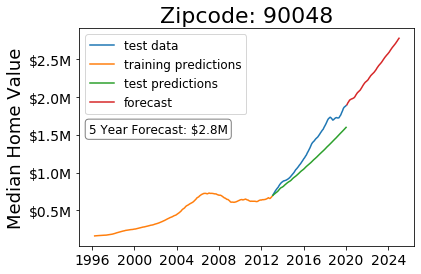

In [26]:
fig, ax = plt.subplots()

# Re-fit model for forecasts using train AND test data
model_for_forecast = ARIMA(fr_list[4], (12,2,0)).fit()
forecast = model_for_forecast.forecast(steps=60)

# Plot train, test, predictions
ax.plot(fr_test[4], label='test data')
ax.plot(train_pred_list[4], label='training predictions')
ax.plot(pred_list_test[4], label='test predictions')
ax.plot(pd.DataFrame(forecast[0], index = forecast_range), label='forecast')

# Set title and axis labels
plt.title("Zipcode: " + codes_full_range[4], fontsize=22)
plt.ylabel("Median Home Value", fontsize=18)

#Format y axis for millions of dollars
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '$' + '{:,.1f}'.format(x/1000000.0) + 'M'))

# Adjust Font Size
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=12)

# Add Text Box Showing Forecasted Value in 5 Years
textstr = '5 Year Forecast: $' + str(round(forecast[0][-1] / 1000000, 1)) + 'M'
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax.text(0.028, 0.52, textstr, transform=ax.transAxes, fontsize=12, bbox=props)

In each of the above graphs we can see that our test predictions captured the trends in the test data, but were not perfectly accurate.  Improving these test predictions will be a focus of future iterations of this project.

The red forecast lines show the projected increase in value of an investment made today in the recommended zipcode over the investor's 5 year time horizon.